# Learning to CIFAR Back!
The CIFAR-10 dataset is a benchmark for computer vision tasks dating to [2009](https://www.cs.toronto.edu/~kriz/cifar.html). We construct a model capable of disentangling an input image created by averaging two random samples from CIFAR-10 and predicting the categories of the two components. We achieve 80% accuracy with an F1 Score of ?. 

This novel task requires training on small datasets (order of 50,000 samples) with small spatial resolution (32x32x3). We overcome this difficulty by eliminating max pooling operations in favor of an All Convolutional Model, inspired by the (second place CIFAR-10 holders)[https://arxiv.org/abs/1412.6806]. The writeup takes the form of a Jupyter notebook, first displaying our most capable model, then chronologically detailing how we arrived to this result.

### 80% Accuracy ACNN3
![ACCN3](ACCN3.png)
### Description
The model has a feature extractor composed purely of two dimensional convolutions. Instead of maxpooling, down sampling the spatial resolution is accomplished by a stride of 2. The extractor reduces the resolution to a stack of 192 2x2 filters. This is flattened and passed to two independent classifiers. They are single layer fully connected layers, with a softmax to produce the 5 possible class probabilities. The network has 20% dropout layers after the stride 2 convolutions to prevent overfitting and no data augmentation, as it did not lead to better results. The standard optimizer has been replaced with [Adagrad](https://keras.io/api/optimizers/adagrad/) which lead to slow but stable convergence. Each classifier has its own cross entropy loss to back propagate through the network, and we observe they do not improve equally, an area for further research on the task.

# Experimental Setup
The reader is invited to train locally by uncommenting the **fit()** calls where indicated.
### Libraries

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.nn import fractional_max_pool
from keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import Callback
from keras.saving import load_model, save_model, save_weights
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Data Preparation

In [2]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

# Split part of the training set into validation set
cifar10_x_train, cifar10_x_val, cifar10_y_train, cifar10_y_val = train_test_split(
    cifar10_x_train, cifar10_y_train, test_size=0.1
)

# First classifier: "airplane", "automobile", "bird", "cat", "deer"
# Second classifier: "dog", "frog", "horse", "ship", "truck"
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Normalizing to range (0,1)
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_val = (cifar10_x_val / 255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Split the images in two groups, according to their label.

In [3]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_val = cifar10_y_val[:,0] < 5
cifar10_x_val_1 = cifar10_x_val[cond_1_val]
cifar10_y_val_1 = cifar10_y_val[cond_1_val]

cond_2_val = cifar10_y_val[:,0] >= 5
cifar10_x_val_2 = cifar10_x_val[cond_2_val]
cifar10_y_val_2 = cifar10_y_val[cond_2_val]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a dictionary of batches of labels corresponding to the component images, expressed in categorical format, in other words, one hot encoded.

In [4]:
batchsize = 64

def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = {'output1': Y1_cat[num1], 'output2': Y2_cat[num2]}
    yield tf.convert_to_tensor(x_data), y_data

traingen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,batchsize)
valgen = datagenerator(cifar10_x_val_1,cifar10_x_val_2,cifar10_y_val_1,cifar10_y_val_2,batchsize)
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,1000)

We generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

The reader is invited to re-run the cell to display new examples.

first: cat, second = dog


[]

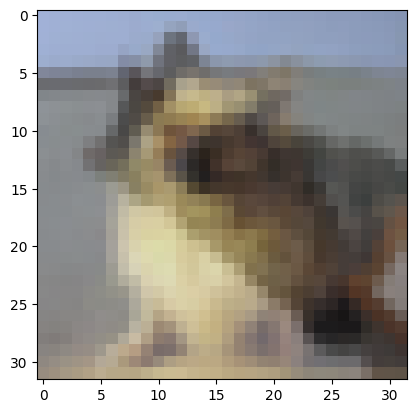

In [5]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)
x, y = next(datagen)
print("first: {}, second = {}".format(classes[np.argmax(y['output1'][0])],classes[np.argmax(y['output2'][0])+5]))
plt.imshow(x[0])
plt.plot()

### Model Evaluation
We create our evaluation method and test it with a model which generates random classes.

In [6]:
def random_model():
    inputs = keras.Input(shape=(32,32,3))
    x = layers.Flatten()(inputs)
    output1 = layers.Dense(5, name='output1')(x)
    output2 = layers.Dense(5, name='output2')(x)
    model = keras.Model(
    inputs,
    outputs={'output1':output1, 'output2':output2}, name='Toy',
    )
    model.compile(
    optimizer='Adam', 
    loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
    metrics={'output1':'accuracy', 'output2':'accuracy'})
    return model

def evaluate_model(model, gen, steps=10, repeat=10, classes=classes):
    y1 = []
    pred1 = []
    y2 = []
    pred2 = []
    
    for _ in tqdm(range(steps * repeat)):
        # Generator returns 1000 image batches
        x, y = next(gen)
        
        y1.extend(np.argmax(y['output1'], axis=1))
        y2.extend(np.argmax(y['output2'], axis=1))
        
        pred = model.predict(x, verbose=0)
        pred1.extend(np.argmax(pred['output1'], axis=1))
        pred2.extend(np.argmax(pred['output2'], axis=1))
    
    acc1 = accuracy_score(y1, pred1)
    acc2 = accuracy_score(y2, pred2)
    mean_accuracy = np.mean([acc1, acc2])
    std_accuracy = np.std([acc1, acc2])
    print(f"First Classifier Accuracy: {acc1:.4f}")
    print(f"Second Classifier Accuracy: {acc2:.4f}")
    print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    
    cm1 = confusion_matrix(y1, pred1)
    cm2 = confusion_matrix(y2, pred2)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes[:5] if classes else None, 
                yticklabels=classes[:5] if classes else None, ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('First Classifier Confusion Matrix')
    
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes[5:10] if classes else None, 
                yticklabels=classes[5:10] if classes else None, ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Second Classifier Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

100%|██████████| 100/100 [00:05<00:00, 16.84it/s]


First Classifier Accuracy: 0.1899
Second Classifier Accuracy: 0.1865
Mean Accuracy: 0.1882 ± 0.0017


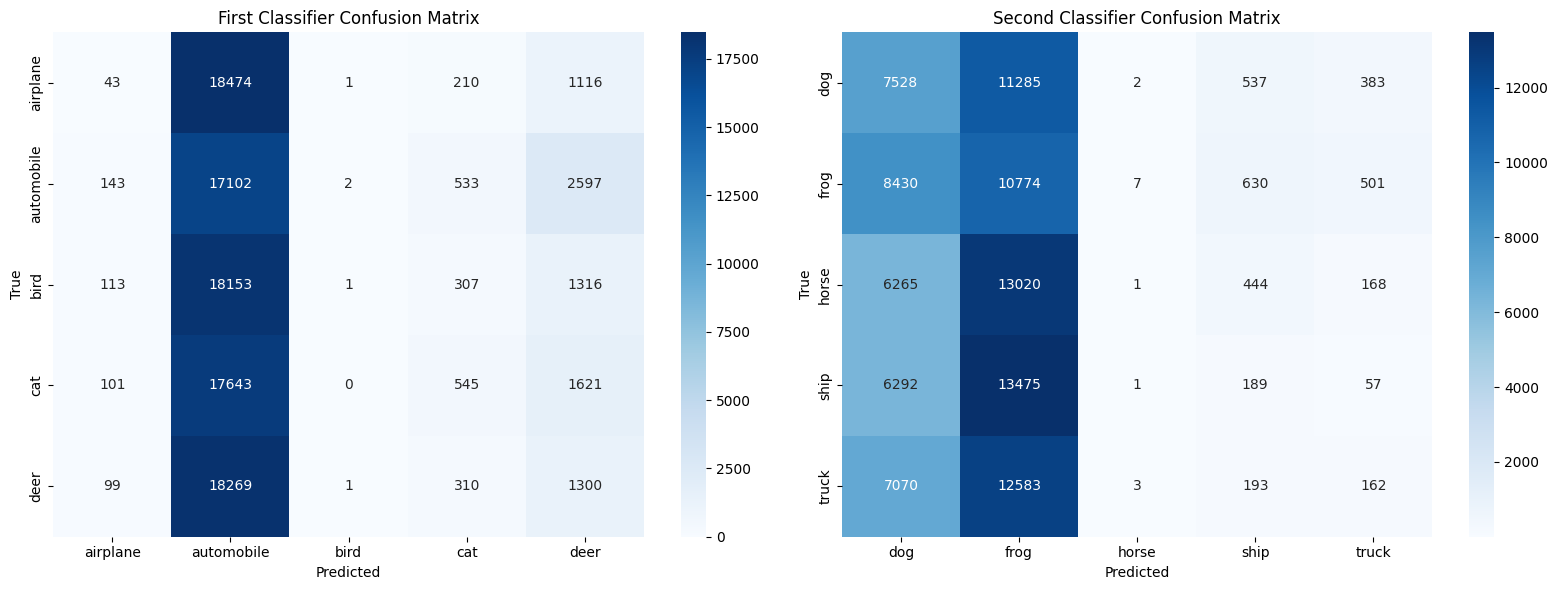

In [39]:
model = random_model()
evaluate_model(model, testgen)

As expected, the accuracy is around 1/5 = 0.2! We repeat the evaluation ten times, and compute the standard deviation. This is how we compute our official project result. No more waiting, we load our top model weights to report!

100%|██████████| 100/100 [02:24<00:00,  1.44s/it]


First Classifier Accuracy: 0.7291
Second Classifier Accuracy: 0.8141
Mean Accuracy: 0.7716 ± 0.0425


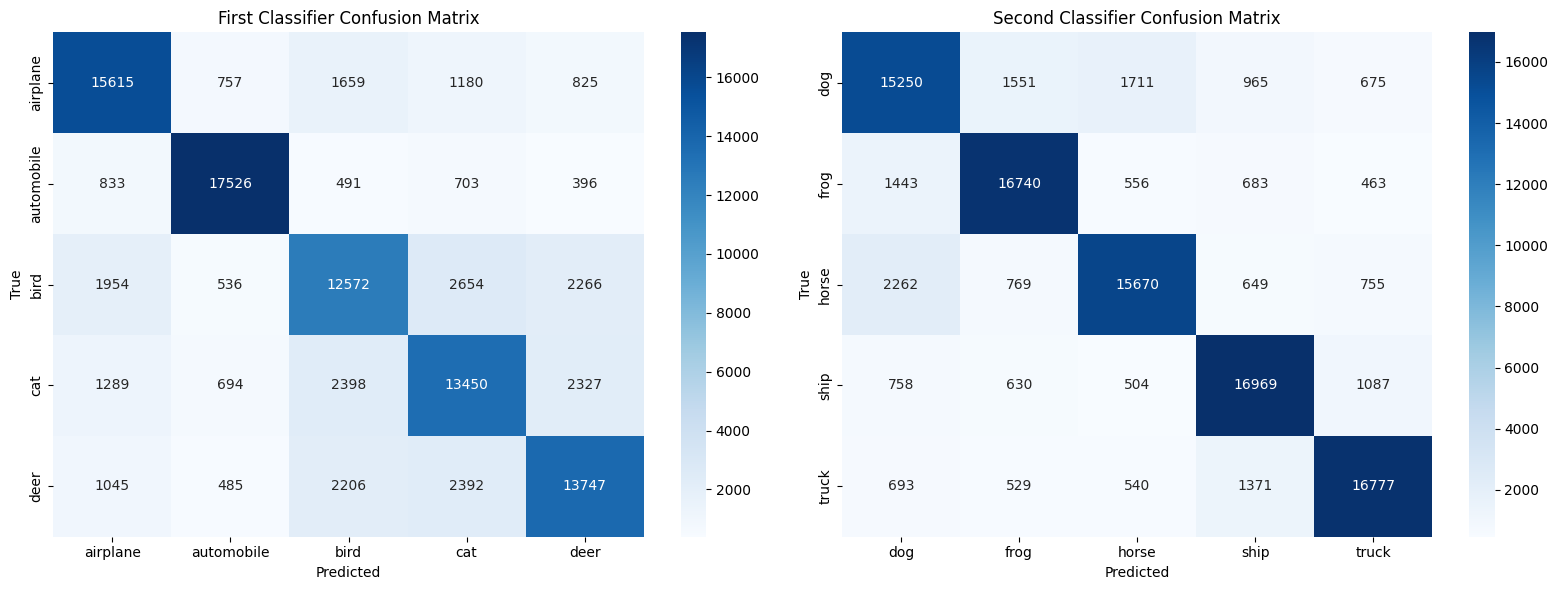

In [40]:
model = load_model('77.2acc.keras')
evaluate_model(model, testgen)

As stated in the beginning, our model performs admirably with an accuracy of 77.2\%! From the confusion matrices, we can see it performs about equally well on all classes. However, the first classifier has greater difficulty than the second. We know this from the lower accuracy score and confusion between animals: notice the shaded areas for deer, cat, and bird!
### Model Checkpoints
We implement a custom model callback to save the model weights when the average accuracy of both classifiers improves during training. Without this, we would be forced to use a proxy like loss for the metric we care about the most. We use the validation accuracy since it is representative of the unseen data the model will see during testing. This being said, we did not use this often since training was fast and it saved a lot of models!

In [42]:
class MeanAccModelCheckpoint(Callback):
    def __init__(self, filepath, monitor1='val_output1_accuracy', monitor2='val_output2_accuracy', mode='max', verbose=1):
        super(MeanAccModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor1 = monitor1
        self.monitor2 = monitor2
        self.mode = mode
        self.verbose = verbose
        self.best_score = -float('inf') if mode == 'max' else float('inf')

    # Called at the end of an epoch during training
    def on_epoch_end(self, epoch, logs=None):
        acc1 = logs.get(self.monitor1)
        acc2 = logs.get(self.monitor2)

        # Compute the average accuracy
        avg_accuracy = (acc1 + acc2) / 2 if acc1 is not None and acc2 is not None else None

        if avg_accuracy is not None:
            if (self.mode == 'max' and avg_accuracy > self.best_score) or \
               (self.mode == 'min' and avg_accuracy < self.best_score):
                # Update the best score
                self.best_score = avg_accuracy
                
                # Format the filepath
                save_path = self.filepath.format(
                    output1_accuracy=acc1,
                    output2_accuracy=acc2,
                    epoch=epoch + 1,  # Epoch is zero-indexed
                    loss=logs.get('loss')
                )
                
                # Save the model
                if self.verbose:
                    print(f"\nEpoch {epoch + 1}: Average accuracy improved to {avg_accuracy:.4f}, saving model to {save_path}")
                self.model.save(save_path)
            elif self.verbose:
                print(f"\nEpoch {epoch + 1}: Average accuracy did not improve (current: {avg_accuracy:.4f}, best: {self.best_score:.4f})")


We use the built in callback for early stopping so we do not have to worry about training for too few or too many epochs. When the validation loss stops decreasing, the model will try ten more times to improve or revert to the best weights. The validation loss metric is an average of the validation losses of each one of the two classifiers. We also use a built in callback to lower the learning rate when training stalls, to converge to better results.

In [43]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                patience=10,         
                                mode='min',         
                                restore_best_weights=True,  
                                verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                factor=0.2,
                                patience=5, 
                                min_lr=0.000001, 
                                verbose=1)

### Model Creation
We use the Keras Functional API to create our model.

In [44]:
def ACCNRR():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    inputs = layers.RandomFlip("horizontal")(inputs)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x = layers.GlobalAveragePooling2D()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1', kernel_regularizer=regularizers.l2(0.01))(x)
    output2 = layers.Dense(5, activation='softmax', name='output2', kernel_regularizer=regularizers.l2(0.01))(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNRR',
        )
    return model

We use the garbage collector to free all memory, then load and compile the model with its hyperparamters. The optimizer is RMS Prop, which combined with reducing learning rate over training leads to stable training. We apply label smoothing to the classifier losses, since the signal is quite noisy this will help with learning. Finally, we display the model summary and ascertain its size as a medium model, at over 1 Million trainable parameters.

In [47]:
K.clear_session()
model = ACCNRR()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})


model.summary()

Model: "ACCNRR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ keras_tensor_1CL… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[2][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[2][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[2][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[2][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[2][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[2][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_6[2][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_7[2][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,374,730 (5.24 MB)

 Trainable params: 1,372,234 (5.23 MB)

 Non-trainable params: 2,496 (9.75 KB)

Run the code cell below to train it for yourself!

In [ ]:
# history = model.fit(
#     traingen,            
#     epochs=250,          
#     steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
#     validation_data=valgen,
#     validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
#     callbacks=[early_stopping, reduce_lr],
#     verbose=1
# )
model.load('77.2acc.keras')

Evaluate the model for yourself! This will match the results we shared earlier!

In [ ]:
# evaluate_model(model, testgen)

# Experimental Setup
As the reader might imagine, one does not simply invent a top performing model. The first step was idea generation and research. A few key points:
- CIFAR-10 is a small dataset
- Images in CIFAR-10 only measure 32x32 pixels
- Classifying CIFAR-10 is a very popular project
- Everything was to be implemented in Keras and TensorFlow

Since CIFAR-10 is a small dataset, the model should be slim, it should have strong regularization to avoid overfitting and the dataset should be augmented to help it generalize. It was also a shame to divide training data to create the validation set, this could be mitigated with a smarter data generator and k fold validation.
Since we knew our library, we should take full advantage of its tools, namely the Functional API, so we spend more time experimenting and less troubleshooting.
Most importantly, since CIFAR-10 is popular, we would be able to adapt an existing top performer to this task by adding a second classification head.
### Research
We googled "CIFAR-10 best accuracy" and fell upon a reddit post about a person trying to train it as [fast as possible](https://github.com/tysam-code/hlb-CIFAR10). However, we are not interested in light speed CIFAR-10, so we tried again, googling only "CIFAR-10" and finding the main website for this [dataset](https://www.cs.toronto.edu/~kriz/cifar.html). From there, we discovered the [world rankings](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130). Now we will read these papers in order and apply the knowledge within to train our model. The first is [Fractional Max Pooling](https://arxiv.org/abs/1412.6071), with an accuracy of 96.53%. As we read this, a doubt strikes us, is the task similar enough? For example, as a human, it is harder distinguish the two classes than just one... Presumably, the model will struggle more as well.
### Fractional Max Pooling
The innovation of this paper is to allow max pooling to reduce the spatial size of the features by less than an integer factor. This will allow slower data compression and make training easier. For example, the paper finds good results with a factor of 
$$
\sqrt{2} \approx 1.41
$$
rather than 2, the lowest integer factor. The authors of the paper use compressed notation to express their CIFAR-10 model.
$$
(160 n C2 −FMP \sqrt[3]{2})_{12} −C2 −C1 −output
$$
It took several iterations to translate in code. Along the way, we decided to subclass keras.Model() rather than use the Functional API since fractional max pooling is a custom layer. The general model architecture is a feature extractor whose filters increases linearly by 160 each layer, followed  by the fractional max pool which downsamples by 1.26, repeated 10 times. The C2 represents a 2x2 kernel. At the end, there is a 1x1 kernel to lower the feature maps then a one layer fully connected classifier. The architecture with best performance we obtained is below.


In [7]:
@keras.saving.register_keras_serializable()
class FMP3(Model):
    def __init__(self):
        super(FMP3, self).__init__()
        # Input layer size 32x32

        # Six convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(32, (2, 2), activation=LeakyReLU())
        self.conv2 = layers.Conv2D(64, (2, 2), activation=LeakyReLU())
        self.conv3 = layers.Conv2D(96, (2, 2), activation=LeakyReLU())
        self.conv4 = layers.Conv2D(128, (2, 2), activation=LeakyReLU())
        self.conv5 = layers.Conv2D(160, (2, 2), activation=LeakyReLU())
        self.conv6 = layers.Conv2D(192, (2, 2), activation=LeakyReLU())

        # Six fractional max pooling layers
        self.pooling_ratio1 = [1.0, 31/22, 31/22, 1.0]
        self.pooling_ratio2 = [1.0, 21/15, 21/15, 1.0]
        self.pooling_ratio3 = [1.0, 14/10, 14/10, 1.0]
        self.pooling_ratio4 = [1.0, 9/6, 9/6, 1.0]
        self.pooling_ratio5 = [1.0, 5/4, 5/4, 1.0]
        self.pooling_ratio6 = [1.0, 3/2, 3/2, 1.0]

        # Two final convolutional layers
        self.conv7 = layers.Conv2D(192, (2, 2), activation=LeakyReLU()) # 4x4
        self.conv8 = layers.Conv2D(192, (1, 1), activation=LeakyReLU())

        # Linearly increasing dropout in the hidden layers
        self.dropout = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Two Classifiers 
        self.fc1 = layers.Dense(5, activation='softmax', name='output1')  # First half
        self.fc2 = layers.Dense(5, activation='softmax', name='output2')  # Second half

    def call(self, inputs):
        # Feature Extractor
        x = self.conv1(inputs) # 31x31
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True) # 22x22
        x = self.conv2(x) # 21x21
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True) # 15x15
        x = self.conv3(x) # 14x14
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True) # 10x10
        x = self.conv4(x) # 9x9
        x, _, _ = fractional_max_pool(x, self.pooling_ratio4, pseudo_random=True, overlapping=True) # 6x6
        x = self.conv5(x) #5x5
        x, _, _ = fractional_max_pool(x, self.pooling_ratio5, pseudo_random=True, overlapping=True) # 4x4
        x = self.conv6(x) # 3x3
        x, _, _ = fractional_max_pool(x, self.pooling_ratio6, pseudo_random=True, overlapping=True) # 2x2
        x = self.conv7(x) # 1x1
        # IDEA: dropout here at 25%
        x = self.conv8(x) #1x1

        # Classifier
        x = layers.Flatten()(x) # future improvement might be to use global average pooling to lower the FCN parameter count
        x = self.dropout(x)
        output1 = self.fc1(x)  # First half
        output2 = self.fc2(x)  # Second half

        return {'output1': output1, 'output2': output2}
    
    def get_config(self):
        # Serialize the configuration of the model
        config = super(FMP3, self).get_config()
        config.update({
            'conv1': self.conv1.get_config(),
            'conv2': self.conv2.get_config(),
            'conv3': self.conv3.get_config(),
            'conv4': self.conv4.get_config(),
            'conv5': self.conv5.get_config(),
            'conv6': self.conv6.get_config(),
            'conv7': self.conv7.get_config(),
            'conv8': self.conv8.get_config(),
            'dropout': self.dropout.get_config(),
            'fc1': self.fc1.get_config(),
            'fc2': self.fc2.get_config(),
            'pooling_ratios': [
                self.pooling_ratio1,
                self.pooling_ratio2,
                self.pooling_ratio3,
                self.pooling_ratio4,
                self.pooling_ratio5,
                self.pooling_ratio6
            ]
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls()

It is substantially smaller than the model from the paper. Since we used a custom max pooling layer, this model was not optimized for CUDA and was CPU bottlenecked during training. Below, we verify the model size is under 500,000 parameters!

In [12]:
K.clear_session()
model = FMP3()
model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'fmp3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "fmp3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │        82,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │       123,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output1 (Dense)                 │ ?                      │           965 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output2 (Dense)                 │ ?                      │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474,410 (1.81 MB)

 Trainable params: 474,410 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Train or load the best model weights to evaluate it.

In [14]:
# history = model.fit(
#     traingen,            # Training data generator
#     epochs=100,          # Number of epochs to train
#     steps_per_epoch=len(cifar10_x_train)//batchsize,
#     validation_data=valgen,  # Validation data generator
#     validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
#     callbacks=[early_stopping],  # Early stopping callback
#     verbose=2
# )
model = load_model('FMP3/0.67-0.74-epoch37-loss1.52.keras')

100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


First Classifier Accuracy: 0.6581
Second Classifier Accuracy: 0.7383
Mean Accuracy: 0.6982 ± 0.0401


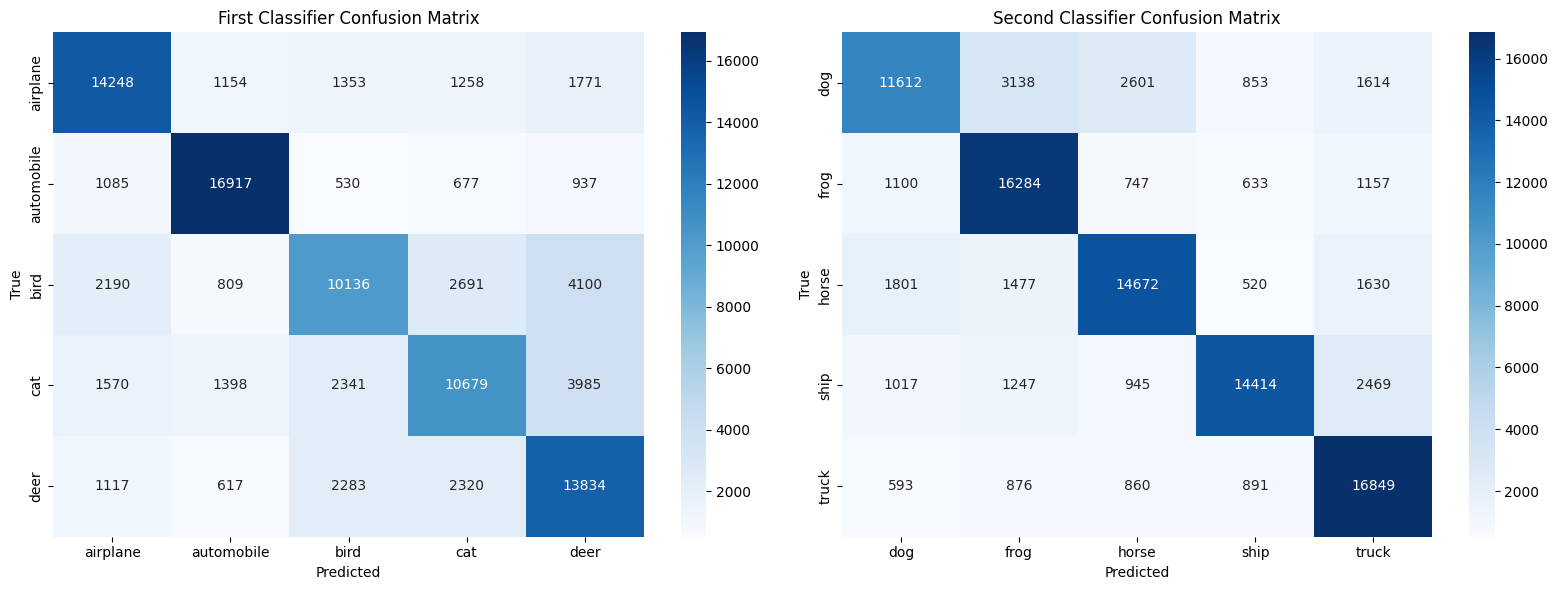

In [10]:
evaluate_model(model, testgen)

Along the way, we developed many new skills. Some of the problems:
- overfitting from no checkpointing or early stopping
- understanding the paper's notation
- data augmentation in the form of horizontal flipping and pixel translation, which reduced performance
- optimizing two losses from seperate heads
- dropout making the gradient too noisy, stalling training
- model.summary() not working on custom models without running dummy tensors through [39-upvote-answer](https://stackoverflow.com/questions/55908188/this-model-has-not-yet-been-built-error-on-model-summary)
- fit_generator() deprecated in favor of [fit()](https://keras.io/api/models/model_training_apis/) but plenty of documentation on the internet still exists [1]((https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/)), [2](https://datascience.stackexchange.com/questions/67266/how-to-write-a-generator-for-keras-fit-generator)
- creating [our own data generator class](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) which inherits from Keras Sequences
- why was the generator was not working with fit()? The output of the generator must have a dictionary whose entries [match those of the model](https://stackoverflow.com/questions/44036971/multiple-outputs-in-keras) when compiled, and the last layers must be named as well as the objects, or else if does not work in the Functional API
- with **tqdm** we first imported it directly, then remembered we have the import the module with the same name as the library
- custom model saving and loading requires a [decorator](https://keras.io/api/models/model_saving_apis/serialization_utils/)

The Fractional Max Pooling claimed an accuracy of 96.53%, which we do not come close to reaching. We implement a behemeoth 62 Million parameter network. We decide to perform more research. We read the following.

*In summary, I personally think the good performance in the Fractional Max-Pooling paper is achieved by a combination of using spatially-sparse CNN with fractional max-pooling and small filters (and network in network) which enable building a deep network even when the input image spatial size is small. Hence in regular CNN network, simply replace regular max pooling with fractional max pooling does not necessarily give you a better performance. [Zhongyu Kuang](https://stackoverflow.com/questions/39886715/fractional-max-pooling-in-tensorflow)*

This makes sense and we head back to the best performing page, to read the second top performing model [STRIVING FOR SIMPLICITY:
THE ALL CONVOLUTIONAL NET](https://arxiv.org/abs/1412.6806) with a reported accuracy of 95.59\%. This model uses standard layers, and is therefore easier to implement since we can use the Functional API. This saves time, allowing for more experimentation! The paper does a nice job describing its architectural choices, summarizing their results compared to other models including our first try in this table.  
![Model Comparison](CIFAR10-Classification-Error.png)

We implement our own versions.

In [43]:
def ACCN():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x = layers.GlobalAveragePooling2D()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1')(x)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCN',
        )
    return model

With a lot of experiementation, we reach the state of the art we shared earlier. Now, let's make a final groundbreaking change, we will take in a much larger input image!

# ** ---------------------------------------- ** ** ---------------------------------------- **

In [17]:
def LACNN():
    # CIFAR-10 Large
    inputs = keras.Input(shape=(126,126,3))
    # Feature Extractor
    x = layers.Conv2D(320, (2,2), activation=LeakyReLU())(inputs)
    x = layers.Conv2D(320, (2,2), activation=LeakyReLU())(x)
    x = layers.Conv2D(320, (2,2), activation=LeakyReLU(), strides=2)(x)

    x = layers.Dropout(0.1)(layers.Conv2D(640, (2,2), activation=LeakyReLU())(x))
    x = layers.Dropout(0.1)(layers.Conv2D(640, (2,2), activation=LeakyReLU())(x))
    x = layers.Conv2D(640, (2,2), activation=LeakyReLU(), strides=2)(x)

    x = layers.Dropout(0.2)(layers.Conv2D(960, (2,2), activation=LeakyReLU())(x))
    x = layers.Dropout(0.2)(layers.Conv2D(960, (2,2), activation=LeakyReLU())(x))
    x = layers.Conv2D(960, (2,2), activation=LeakyReLU(), strides=2)(x)

    x = layers.Dropout(0.3)(layers.Conv2D(1280, (2,2), activation=LeakyReLU())(x))
    x = layers.Dropout(0.3)(layers.Conv2D(1280, (2,2), activation=LeakyReLU())(x))
    x = layers.Conv2D(960, (2,2), activation=LeakyReLU(), strides=2)(x)

    x = layers.Dropout(0.4)(layers.Conv2D(1600, (2,2), activation=LeakyReLU())(x))
    x = layers.Dropout(0.4)(layers.Conv2D(1600, (2,2), activation=LeakyReLU())(x))
    x = layers.Conv2D(1600, (2,2), activation=LeakyReLU(), strides=2)(x)

    x = layers.Dropout(0.5)(layers.Conv2D(1920, (2,2), activation=LeakyReLU())(x))
    #x = layers.Dropout(0.5)(layers.Conv2D(1920, (2,2), activation=LeakyReLU())(x))

    # Classifers
    x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1', kernel_regularizer=regularizers.l2(0.01))(x)
    output2 = layers.Dense(5, activation='softmax', name='output2', kernel_regularizer=regularizers.l2(0.01))(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='LACNN',
        )
    return model

In [18]:
K.clear_session()
model = LACNN()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(), 'output2': keras.losses.CategoricalCrossentropy()},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()

Model: "LACNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 126, 126,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 125, 125,  │      4,160 │ input_layer[0][0] │
│                     │ 320)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 124, 124,  │    409,920 │ conv2d[0][0]      │
│                     │ 320)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 62, 62,    │    409,920 │ conv2d_1[0][0]    │
│                     │ 320)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 61, 61,    │    819,840 │ conv2d_2[0][0]    │
│                     │ 640)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 61, 61,    │          0 │ conv2d_3[0][0]    │
│                     │ 640)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │  1,639,040 │ dropout[0][0]     │
│                     │ 640)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60, 60,    │          0 │ conv2d_4[0][0]    │
│                     │ 640)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 30, 30,    │  1,639,040 │ dropout_1[0][0]   │
│                     │ 640)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 29, 29,    │  2,458,560 │ conv2d_5[0][0]    │
│                     │ 960)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 29, 29,    │          0 │ conv2d_6[0][0]    │
│                     │ 960)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  3,687,360 │ dropout_2[0][0]   │
│                     │ 960)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 28, 28,    │          0 │ conv2d_7[0][0]    │
│                     │ 960)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │  3,687,360 │ dropout_3[0][0]   │
│                     │ 960)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 13, 13,    │  4,916,480 │ conv2d_8[0][0]    │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 13, 13,    │          0 │ conv2d_9[0][0]    │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 12, 12,    │  6,554,880 │ dropout_4[0][0] 

 Total params: 70,080,650 (267.34 MB)

 Trainable params: 70,080,650 (267.34 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
batchsize = 64

def resize_images(images, target_size=(126, 126)):
    # Resize all images in the batch to the target size with padding
    return tf.image.resize_with_pad(images, target_size[0], target_size[1])

def datageneratorlarge(X1, X2, Y1, Y2, batchsize, target_size=(126, 126)):
    size1 = X1.shape[0]
    size2 = X2.shape[0]
    Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
    Y2_cat = tf.keras.utils.to_categorical(Y2 - 5, num_classes=5)

    while True:
        num1 = np.random.randint(0, size1, batchsize)
        num2 = np.random.randint(0, size2, batchsize)
        
        # Generate images
        x1_batch = X1[num1]
        x2_batch = X2[num2]
        
        # Resize and average images
        x1_resized = resize_images(x1_batch, target_size)
        x2_resized = resize_images(x2_batch, target_size)
        x_data = (x1_resized + x2_resized) / 2.0
        
        # Create labels
        y_data = {'output1': Y1_cat[num1], 'output2': Y2_cat[num2]}
        
        yield tf.convert_to_tensor(x_data), y_data

# Update data generators
traingenlarge = datageneratorlarge(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, batchsize)
valgenlarge = datageneratorlarge(cifar10_x_val_1, cifar10_x_val_2, cifar10_y_val_1, cifar10_y_val_2, batchsize)
testgenlarge = datageneratorlarge(cifar10_x_test_1, cifar10_x_test_2, cifar10_y_test_1, cifar10_y_test_2, 1000)


In [20]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=20,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-9, verbose=1)
history = model.fit(
    traingenlarge,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgenlarge,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/250
  4/703 ━━━━━━━━━━━━━━━━━━━━ 8:45:50 45s/step - loss: 3.4063 - output1_accuracy: 0.1771 - output2_accuracy: 0.2220

KeyboardInterrupt: 

# ** ---------------------------------------- ** ** ---------------------------------------- **

In [44]:
K.clear_session() # garbage collection
model = ACCN()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Model: "ACCN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,374,730 (5.24 MB)

 Trainable params: 1,372,234 (5.23 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 2.9636 - output1_accuracy: 0.3880 - output1_loss: 1.5019 - output2_accuracy: 0.4188 - output2_loss: 1.4617 - val_loss: 2.7082 - val_output1_accuracy: 0.4233 - val_output1_loss: 1.4208 - val_output2_accuracy: 0.5280 - val_output2_loss: 1.2874
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.4176 - output1_accuracy: 0.5089 - output1_loss: 1.2855 - output2_accuracy: 0.6121 - output2_loss: 1.1321 - val_loss: 2.4614 - val_output1_accuracy: 0.4850 - val_output1_loss: 1.3249 - val_output2_accuracy: 0.6084 - val_output2_loss: 1.1365
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.2226 - output1_accuracy: 0.5649 - output1_loss: 1.1966 - output2_accuracy: 0.6745 - output2_loss: 1.0260 - val_loss: 2.4530 - val_output1_accuracy: 0.4904 - val_output1_loss: 1.3271 - val_output2_accuracy: 0.6272 - val_output2_loss: 1.1259
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.1361 - output1_accuracy

In [45]:
evaluate_model(model, testgen)

  0%|          | 0/10 [00:00<?, ?it/s]2025-01-11 10:50:04.735908: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 240 bytes spill stores, 240 bytes spill loads

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

mean accuracy =  0.7378099918365478
standard deviation =  0.002947435931252253


In [46]:
model.save('73.7acc.keras')

In [47]:
from tensorflow.keras.optimizers import RMSprop

# Custom small learning rate
learning_rate = 1e-5  # You can adjust this value as needed for fine-tuning

# Compile model with RMSprop optimizer and label smoothing for the loss
model.compile(optimizer=RMSprop(learning_rate=learning_rate),
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 1.4546 - output1_accuracy: 0.8030 - output1_loss: 0.7910 - output2_accuracy: 0.8693 - output2_loss: 0.6636 - val_loss: 1.7747 - val_output1_accuracy: 0.7071 - val_output1_loss: 0.9820 - val_output2_accuracy: 0.8059 - val_output2_loss: 0.7927
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4325 - output1_accuracy: 0.8118 - output1_loss: 0.7723 - output2_accuracy: 0.8720 - output2_loss: 0.6602 - val_loss: 1.7696 - val_output1_accuracy: 0.7031 - val_output1_loss: 0.9653 - val_output2_accuracy: 0.8047 - val_output2_loss: 0.8043
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4255 - output1_accuracy: 0.8118 - output1_loss: 0.7753 - output2_accuracy: 0.8774 - output2_loss: 0.6502 - val_loss: 1.7639 - val_output1_accuracy: 0.7073 - val_output1_loss: 0.9700 - val_output2_accuracy: 0.8021 - val_output2_loss: 0.7939
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4214 - output1_accuracy

In [48]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

mean accuracy =  0.7620449990034104
standard deviation =  0.0027785288122172164


In [49]:
model.save('76.2acc.keras')

In [53]:
# Custom small learning rate
learning_rate = 1e-7 # You can adjust this value as needed for fine-tuning

# Compile model with RMSprop optimizer and label smoothing for the loss
model.compile(optimizer='adagrad',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 1.3996 - output1_accuracy: 0.8182 - output1_loss: 0.7606 - output2_accuracy: 0.8823 - output2_loss: 0.6390 - val_loss: 1.7521 - val_output1_accuracy: 0.7173 - val_output1_loss: 0.9571 - val_output2_accuracy: 0.8025 - val_output2_loss: 0.7950
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 1.4034 - output1_accuracy: 0.8239 - output1_loss: 0.7555 - output2_accuracy: 0.8791 - output2_loss: 0.6480 - val_loss: 1.7386 - val_output1_accuracy: 0.7137 - val_output1_loss: 0.9600 - val_output2_accuracy: 0.8135 - val_output2_loss: 0.7786
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4068 - output1_accuracy: 0.8209 - output1_loss: 0.7576 - output2_accuracy: 0.8804 - output2_loss: 0.6492 - val_loss: 1.7251 - val_output1_accuracy: 0.7145 - val_output1_loss: 0.9411 - val_output2_accuracy: 0.8103 - val_output2_loss: 0.7840
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 1.3956 - output1_accuracy

In [54]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

mean accuracy =  0.7644650042057037
standard deviation =  0.0022757387857020393


In [55]:
model.save('76.4acc.keras')

In [56]:
def ACCNR():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    inputs = layers.RandomFlip("horizontal")(inputs)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1')(x)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNR',
        )
    return model

In [57]:
K.clear_session() # garbage collection
model = ACCNR()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Model: "ACCNR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ keras_tensor_1CL… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[1][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[1][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_6[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_7[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,374,730 (5.24 MB)

 Trainable params: 1,372,234 (5.23 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 2.9606 - output1_accuracy: 0.3894 - output1_loss: 1.5017 - output2_accuracy: 0.4277 - output2_loss: 1.4589 - val_loss: 2.7054 - val_output1_accuracy: 0.4345 - val_output1_loss: 1.4062 - val_output2_accuracy: 0.5254 - val_output2_loss: 1.2992
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.4157 - output1_accuracy: 0.5137 - output1_loss: 1.2839 - output2_accuracy: 0.6157 - output2_loss: 1.1319 - val_loss: 2.5296 - val_output1_accuracy: 0.4830 - val_output1_loss: 1.3551 - val_output2_accuracy: 0.5811 - val_output2_loss: 1.1745
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.2331 - output1_accuracy: 0.5686 - output1_loss: 1.1978 - output2_accuracy: 0.6686 - output2_loss: 1.0353 - val_loss: 2.5885 - val_output1_accuracy: 0.4587 - val_output1_loss: 1.3796 - val_output2_accuracy: 0.5663 - val_output2_loss: 1.2089
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.1317 - output1_accuracy

In [58]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]

mean accuracy =  0.744294998049736
standard deviation =  0.002647495965331791


In [59]:
# Custom small learning rate
learning_rate = 1e-5  # You can adjust this value as needed for fine-tuning

# Compile model with RMSprop optimizer and label smoothing for the loss
model.compile(optimizer=RMSprop(learning_rate=learning_rate),
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 1.4750 - output1_accuracy: 0.7917 - output1_loss: 0.8013 - output2_accuracy: 0.8653 - output2_loss: 0.6737 - val_loss: 1.7586 - val_output1_accuracy: 0.7079 - val_output1_loss: 0.9746 - val_output2_accuracy: 0.8063 - val_output2_loss: 0.7840
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4559 - output1_accuracy: 0.8002 - output1_loss: 0.7922 - output2_accuracy: 0.8706 - output2_loss: 0.6637 - val_loss: 1.7576 - val_output1_accuracy: 0.7115 - val_output1_loss: 0.9623 - val_output2_accuracy: 0.7977 - val_output2_loss: 0.7953
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4420 - output1_accuracy: 0.8081 - output1_loss: 0.7799 - output2_accuracy: 0.8706 - output2_loss: 0.6621 - val_loss: 1.7502 - val_output1_accuracy: 0.7115 - val_output1_loss: 0.9603 - val_output2_accuracy: 0.8015 - val_output2_loss: 0.7899
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 1.4448 - output1_accuracy

In [60]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]

mean accuracy =  0.7637950003147125
standard deviation =  0.0028752839783437894


In [65]:
# Custom small learning rate
learning_rate = 1e-5  # You can adjust this value as needed for fine-tuning

# Compile model with RMSprop optimizer and label smoothing for the loss
model.compile(optimizer='adam',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 1.4774 - output1_accuracy: 0.7957 - output1_loss: 0.8000 - output2_accuracy: 0.8639 - output2_loss: 0.6774 - val_loss: 1.8565 - val_output1_accuracy: 0.6875 - val_output1_loss: 1.0168 - val_output2_accuracy: 0.7821 - val_output2_loss: 0.8397
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 1.4984 - output1_accuracy: 0.7888 - output1_loss: 0.8117 - output2_accuracy: 0.8598 - output2_loss: 0.6867 - val_loss: 1.8383 - val_output1_accuracy: 0.6945 - val_output1_loss: 0.9821 - val_output2_accuracy: 0.7688 - val_output2_loss: 0.8562
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 1.4799 - output1_accuracy: 0.7961 - output1_loss: 0.7988 - output2_accuracy: 0.8608 - output2_loss: 0.6811 - val_loss: 1.8162 - val_output1_accuracy: 0.6975 - val_output1_loss: 0.9789 - val_output2_accuracy: 0.7867 - val_output2_loss: 0.8373
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 1.4774 - output1_accuracy

In [66]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

mean accuracy =  0.7420600026845932
standard deviation =  0.003503768097391289


In [73]:
from tensorflow.keras import regularizers

def ACCNRR():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    inputs = layers.RandomFlip("horizontal")(inputs)
    #inputs = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(inputs)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1', kernel_regularizer=regularizers.l2(0.01))(x)
    output2 = layers.Dense(5, activation='softmax', name='output2', kernel_regularizer=regularizers.l2(0.01))(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNRR',
        )
    return model

In [74]:
K.clear_session() # garbage collection
model = ACCNRR()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "ACCNRR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ keras_tensor_1CL… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[1][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[1][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_6[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_7[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,374,730 (5.24 MB)

 Trainable params: 1,372,234 (5.23 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 3.0777 - output1_accuracy: 0.3984 - output1_loss: 1.4852 - output2_accuracy: 0.4272 - output2_loss: 1.4491 - val_loss: 3.0848 - val_output1_accuracy: 0.3924 - val_output1_loss: 1.5310 - val_output2_accuracy: 0.4299 - val_output2_loss: 1.4849
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.4576 - output1_accuracy: 0.5138 - output1_loss: 1.2717 - output2_accuracy: 0.6133 - output2_loss: 1.1300 - val_loss: 3.0116 - val_output1_accuracy: 0.4107 - val_output1_loss: 1.5836 - val_output2_accuracy: 0.5054 - val_output2_loss: 1.3981
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.2501 - output1_accuracy: 0.5688 - output1_loss: 1.1965 - output2_accuracy: 0.6711 - output2_loss: 1.0279 - val_loss: 2.4327 - val_output1_accuracy: 0.4992 - val_output1_loss: 1.3186 - val_output2_accuracy: 0.6378 - val_output2_loss: 1.0951
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.1262 - output1_accuracy

In [75]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]

mean accuracy =  0.7449000000953674
standard deviation =  0.0023437179247066614


In [77]:
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=1)
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 1.3606 - output1_accuracy: 0.8392 - output1_loss: 0.7224 - output2_accuracy: 0.8925 - output2_loss: 0.6264 - val_loss: 1.9467 - val_output1_accuracy: 0.6605 - val_output1_loss: 1.0716 - val_output2_accuracy: 0.7730 - val_output2_loss: 0.8633 - learning_rate: 0.0010
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.3802 - output1_accuracy: 0.8349 - output1_loss: 0.7332 - output2_accuracy: 0.8858 - output2_loss: 0.6354 - val_loss: 1.9080 - val_output1_accuracy: 0.6813 - val_output1_loss: 1.0449 - val_output2_accuracy: 0.7778 - val_output2_loss: 0.8519 - learning_rate: 0.0010
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.3739 - output1_accuracy: 0.8349 - output1_loss: 0.7284 - output2_accuracy: 0.8866 - output2_loss: 0.6341 - val_loss: 1.9518 - val_output1_accuracy: 0.6593 - val_output1_loss: 1.0942 - val_output2_accuracy: 0.7804 - val_output2_loss: 0.8460 - learning_rate: 0.0010
Epoch 4/250
703

In [78]:
evaluate_model(model,testgen)

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

mean accuracy =  0.7728849947452545
standard deviation =  0.0034772096260280113


In [79]:
model.save('77.2acc.keras')

In [84]:
def ACCNRR2():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    #inputs = layers.RandomFlip("horizontal")(inputs)
    #inputs = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(inputs)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Conv2D(192, (3,3), activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # Classifers
    x1 = layers.Conv2D(192, (1,1), activation='relu')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)
    x2 = layers.Conv2D(192, (1,1), activation='relu')(x)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1', kernel_regularizer=regularizers.l2(0.01))(x1)
    output2 = layers.Dense(5, activation='softmax', name='output2', kernel_regularizer=regularizers.l2(0.01))(x2)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNRR2',
        )
    return model

In [85]:
K.clear_session() # garbage collection
model = ACCNRR2()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=1)
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "ACCNRR2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,079,818 (4.12 MB)

 Trainable params: 1,077,322 (4.11 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 3.0003 - output1_accuracy: 0.3958 - output1_loss: 1.4703 - output2_accuracy: 0.4535 - output2_loss: 1.3992 - val_loss: 2.8194 - val_output1_accuracy: 0.3658 - val_output1_loss: 1.4871 - val_output2_accuracy: 0.5164 - val_output2_loss: 1.2903 - learning_rate: 0.0010
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.3907 - output1_accuracy: 0.5291 - output1_loss: 1.2516 - output2_accuracy: 0.6290 - output2_loss: 1.1049 - val_loss: 2.5269 - val_output1_accuracy: 0.4954 - val_output1_loss: 1.3755 - val_output2_accuracy: 0.6222 - val_output2_loss: 1.1302 - learning_rate: 0.0010
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.2353 - output1_accuracy: 0.5688 - output1_loss: 1.1941 - output2_accuracy: 0.6793 - output2_loss: 1.0211 - val_loss: 2.7355 - val_output1_accuracy: 0.4581 - val_output1_loss: 1.4114 - val_output2_accuracy: 0.5469 - val_output2_loss: 1.3048 - learning_rate: 0.0010
Epoch 4/250
703

In [86]:
evaluate_model(model,testgen)

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

mean accuracy =  0.7608000040054321
standard deviation =  0.0014462036836579227


In [87]:
def ACCNRR3():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x1 = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(192, (1,1), activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)
    x2 = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(192, (1,1), activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1', kernel_regularizer=regularizers.l2(0.01))(x1)
    output2 = layers.Dense(5, activation='softmax', name='output2', kernel_regularizer=regularizers.l2(0.01))(x2)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNRR3',
        )
    return model

In [88]:
K.clear_session() # garbage collection
model = ACCNRR3()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-9, verbose=1)
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "ACCNRR3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,412,554 (5.39 MB)

 Trainable params: 1,409,674 (5.38 MB)

 Non-trainable params: 2,880 (11.25 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 3.0550 - output1_accuracy: 0.3926 - output1_loss: 1.4776 - output2_accuracy: 0.4317 - output2_loss: 1.4364 - val_loss: 2.6912 - val_output1_accuracy: 0.3962 - val_output1_loss: 1.4266 - val_output2_accuracy: 0.5681 - val_output2_loss: 1.2173 - learning_rate: 0.0010
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.3946 - output1_accuracy: 0.5275 - output1_loss: 1.2529 - output2_accuracy: 0.6273 - output2_loss: 1.1048 - val_loss: 2.7027 - val_output1_accuracy: 0.5032 - val_output1_loss: 1.3021 - val_output2_accuracy: 0.5365 - val_output2_loss: 1.3793 - learning_rate: 0.0010
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.2188 - output1_accuracy: 0.5798 - output1_loss: 1.1796 - output2_accuracy: 0.6786 - output2_loss: 1.0188 - val_loss: 2.3980 - val_output1_accuracy: 0.5397 - val_output1_loss: 1.2643 - val_output2_accuracy: 0.6118 - val_output2_loss: 1.1155 - learning_rate: 0.0010
Epoch 4/250
703

In [89]:
evaluate_model(model,testgen)

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

mean accuracy =  0.7647300004959107
standard deviation =  0.0036044590901915708


In [90]:
def ACCNRR4():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    inputs = layers.RandomFlip("horizontal")(inputs)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x1 = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(192, (1,1), activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)
    x2 = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(192, (1,1), activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1', kernel_regularizer=regularizers.l2(0.01))(x1)
    output2 = layers.Dense(5, activation='softmax', name='output2', kernel_regularizer=regularizers.l2(0.01))(x2)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNRR4',
        )
    return model

In [92]:
K.clear_session() # garbage collection
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=20,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)
model = ACCNRR4()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-9, verbose=1)
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "ACCNRR4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ keras_tensor_1CL… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[1][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[1][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_7[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_6[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,412,554 (5.39 MB)

 Trainable params: 1,409,674 (5.38 MB)

 Non-trainable params: 2,880 (11.25 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 3.0740 - output1_accuracy: 0.3799 - output1_loss: 1.5243 - output2_accuracy: 0.4385 - output2_loss: 1.4133 - val_loss: 3.1164 - val_output1_accuracy: 0.3590 - val_output1_loss: 1.5732 - val_output2_accuracy: 0.4087 - val_output2_loss: 1.5015 - learning_rate: 0.0010
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.4760 - output1_accuracy: 0.5226 - output1_loss: 1.3433 - output2_accuracy: 0.6347 - output2_loss: 1.1008 - val_loss: 2.5771 - val_output1_accuracy: 0.5162 - val_output1_loss: 1.3523 - val_output2_accuracy: 0.5647 - val_output2_loss: 1.2064 - learning_rate: 0.0010
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.3311 - output1_accuracy: 0.5637 - output1_loss: 1.2911 - output2_accuracy: 0.6774 - output2_loss: 1.0228 - val_loss: 2.5407 - val_output1_accuracy: 0.5142 - val_output1_loss: 1.3686 - val_output2_accuracy: 0.5994 - val_output2_loss: 1.1563 - learning_rate: 0.0010
Epoch 4/250
703

In [93]:
evaluate_model(model,testgen)

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

mean accuracy =  0.7578449964523315
standard deviation =  0.003335145901600307
